In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pandas as pd
import seaborn as sns

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import cv2

def shrink(x):
    return torch.nn.functional.interpolate(
        torch.Tensor(x).unsqueeze(0).unsqueeze(0), scale_factor=0.5,
        recompute_scale_factor=True)[0][0].numpy()
    
def get_metrics(gt, pred, i, batch):
    metrics = {'batch': batch, 'idx': i}
    metrics['SSIM'] = ssim(pred, gt, data_range=gt.max() - gt.min())
    metrics['PSNR'] = cv2.PSNR(gt, pred)
    metrics['MAE'] = np.mean(abs(gt - pred))
    metrics['RMSE'] = mean_squared_error(gt, pred)
    metrics['Pearson'] = pearsonr(gt.reshape(-1), pred.reshape(-1))[0]
    metrics['R2'] = r2_score(gt.reshape(-1), pred.reshape(-1))
    
    return metrics

def scale(im, qualtile_clip=False):
    sorted_int_values = np.sort(np.reshape(im, [-1]))
    if qualtile_clip:
        low5, high95 = int(len(sorted_int_values) * 0.025), int(len(sorted_int_values) * 0.9975)
        im_clipped = np.clip(im, a_min=sorted_int_values[low5], a_max=sorted_int_values[high95])
    else:
        im_clipped = im
    im_clipped /= np.max(im_clipped)
    im_clipped = np.clip(im_clipped, -0.2, 2)
    return im_clipped



In [4]:
# file_gt = '/home/anna/data_19Nov2022/real_test.h5'
# file_gt_en = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_MultiGT_EN/Reconstructions/arm_linear_sigmat_multisegment/arm_linear_sigmat_multisegment.h5'
# file_linbm_en = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_LinearGT_EN/Reconstructions/arm_linear_sigmat_multisegment/arm_linear_sigmat_multisegment.h5'

# Ground truth

Back projection

In [5]:
# file_gt_bp = '/home/anna/dlbirhoui_data/arm.h5'
file_gt_bp = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_MultiGT_BP//Reconstructions/arm_multi_sigmat_multisegment///arm_multi_sigmat_multisegment.h5'
# file_gt_bp = '/home/anna/dlbirhoui_data//Reconstructions/arm_multi_sigmat_multisegment//arm_multi_sigmat_multisegment.h5'
gt_rec_bp = h5py.File(file_gt_bp, 'r')
multi_GT_bp = gt_rec_bp['BackProjection']
# print(multi_GT_bp.shape)

# file_gt_bp_lin = '/home/anna/dlbirhoui_data//Reconstructions/arm_linear_sigmat_multisegment//arm_linear_sigmat_multisegment.h5'
file_gt_bp_lin = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_LinearGT_BP//Reconstructions/arm_linear_sigmat_multisegment//arm_linear_sigmat_multisegment.h5'
gt_rec_bp_lin = h5py.File(file_gt_bp_lin, 'r')
linear_GT_bp = gt_rec_bp_lin['BackProjection']
# print(linear_GT_bp.shape)


In [6]:
gt_old = '/home/anna/dlbirhoui_data/arm.h5'
gt_old_rec = h5py.File(gt_old, 'r')
GT_old_rec = gt_old_rec['recon_multisegment']

Elsastic Net

In [7]:
file_gt_en = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_MultiGT_EN/Reconstructions/arm_multi_sigmat_multisegment/arm_multi_sigmat_multisegment.h5'
gt_rec_en = h5py.File(file_gt_en, 'r')
multi_GT_en = gt_rec_en['ElasticNet 1e-5']

file_linbm_en = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_LinearGT_EN/Reconstructions/arm_linear_sigmat_multisegment/arm_linear_sigmat_multisegment.h5'
linbm_rec_en = h5py.File(file_linbm_en, 'r')
linear_GT_en = linbm_rec_en['ElasticNet 1e-5']

# UNet from Firat

In [8]:
# filetgt = h5py.File('/home/anna/OptoAcoustics/data/benchmark_invivo.h5', 'r')
# tgt_exmpls = []
# for i in range(32):
#     tgt_exmpls.append(filetgt['img_num'][i][0])
#     print(filetgt['img_num'][i][0])
    
# print(tgt_exmpls)


In [10]:
# model = 'unet_ellipsesSkinMask_20210412_lin2Ms_scaleclip_MAE'
# file = h5py.File(f'/home/firat/docs/dlbirhoui/parsed_data/armBP_mapping_from_linear.h5', 'r')[model]
# ['recon_multisegment']


In [7]:
## run in case you need to resave the model
# model = 'unet_ellipsesSkinMask_20210412_lin2Ms_scaleclip_MAE'
# file = h5py.File(f'/home/firat/docs/dlbirhoui/parsed_data/armBP_mapping_from_linear.h5', 'r')[model]['recon_multisegment']

# tgt_folder = f'/home/anna/ResultsSignalDA/UNet/'

# nimgs = 5565
# sigmat_size = [256, 256]    
# compression_lvl = 9 # pick between 0 and 9

# # modes_list = ['BackProjection']
# fname_h5 = f'{tgt_folder}/{model}.h5'

# modes_list = ['BackProjection', 'ElasticNet 1e-5']
# print('Creating file: %s' % fname_h5)
# data = {}
# with h5py.File(fname_h5, 'w', libver='latest') as h5_fh:
#     for mode in modes_list:
#         data[mode] =\
#             h5_fh.create_dataset(mode,
#             shape=[nimgs] + sigmat_size, 
#             dtype=np.float32, chunks=tuple([1] + sigmat_size),
#             compression='gzip', compression_opts=compression_lvl)

# with h5py.File(fname_h5, 'a', libver='latest') as h5_fh:
#     for i in range(nimgs):
#         x = shrink(file[i])
#         for mode in modes_list:            
#             h5_fh[mode][i] = x
            

In [11]:
file_unet = '/home/anna/ResultsSignalDA/UNet//unet_ellipsesSkinMask_20210412_lin2Ms_scaleclip_MAE.h5'
# file_unet = '/home/anna/OptoAcoustics//MIDL/from_firat_1024//unet_ellipsesSkinMask_20210412_lin2Ms_scaleclip_MAE.h5'

f_unet = h5py.File(file_unet, 'r')
unet = f_unet['BackProjection'][:]
# # unet = gt_rec_en['ElasticNet 1e-5']

# UNet from Anna

In [12]:
# file_unet = '/home/anna/ResultsSignalDA/UNet-BM//maxpool_l1_BN_2022-12-12/test_arm.h5'
# scale_unet = -1
# file_unet = '//home/anna/ResultsSignalDA/UNet-BM//CorrectScale_l1_BN_2022-12-12/test_arm.h5'

# f_unet = h5py.File(file_unet, 'r')
# unet_2 = scale_unet*f_unet['output'][:]

file_unet = '//home/anna/ResultsSignalDA/UNet-BM//CorrectScale_l1_BN_2022-12-12/test_arm.h5'
# file_unet = '//home/anna/ResultsSignalDA/UNet-BM//NotBilinear_l1_BN_2022-12-13/test_arm.h5'
f_unet = h5py.File(file_unet, 'r')
unet = f_unet['output'][:]





In [13]:
file_unet_en = 'MIAreview/Results/NotBilinear_l1_BN_2023-07-08/test_Real_syn.h5'
f_unet_en = h5py.File(file_unet_en, 'r')
unet_en = f_unet_en['output'][:]

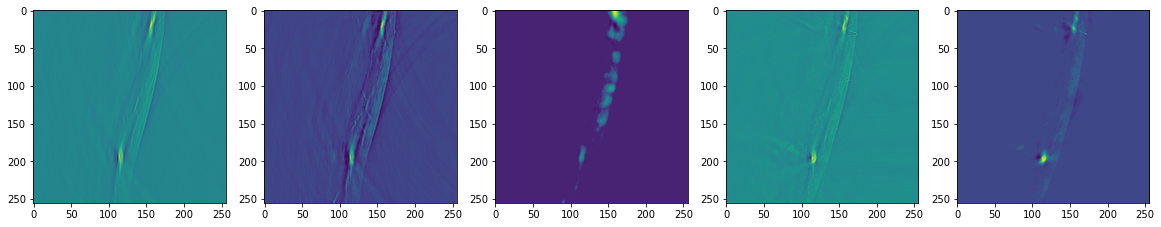

In [14]:
i = np.random.choice(5000)
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
axs[0].imshow(linear_GT_bp[i])
axs[1].imshow(unet[i])
axs[2].imshow(unet_en[i])
axs[3].imshow(multi_GT_bp[i])
# axs[4].imshow(GT_old_rec[i])
axs[4].imshow(multi_GT_en[i])


# fig, axs = plt.subplots(1, 4, figsize=(15, 5))
# axs[0].imshow(linear_GT_bp[i])
# axs[1].imshow(unet_2[i])
# axs[2].imshow(multi_GT_bp[i])
# axs[3].imshow(GT_old_rec[i])


In [15]:
i
# 1341 84

3599

# Metrics

In [16]:
folder_rec = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/reconstruction//MIAstyleLinear__2022-12-09/'
# folder_rec = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/reconstruction//MIAstyleLinear__2022-12-15/'

In [17]:
batch = 0
file_input = f'{folder_rec}/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'

rec = h5py.File(file_input, 'r')
rec_bp = rec['BackProjection']
rec_en = rec['ElasticNet 1e-5']

/home/anna/ResultsSignalDA/comparison_imgs/batch_0_idx_13.png


ValueError: too many values to unpack (expected 5)

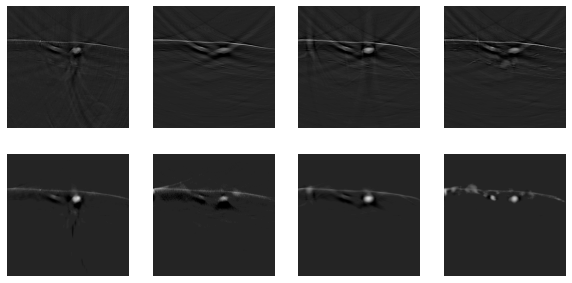

In [18]:
def get_images(i, batch, plot=False, fname=None):
    # gt_old = np.rot90(scale(shrink(GT_old_rec[batch*256+i])), 2)
    
    gt_en = np.rot90(scale(multi_GT_en[batch*256+i], qualtile_clip=False))[:, ::-1]
    gt_lin_en = np.rot90(scale(linear_GT_en[batch*256+i], qualtile_clip=False))[:, ::-1]
    gt_bp = np.rot90(scale(multi_GT_bp[batch*256+i], qualtile_clip=False))[:, ::-1]
    gt_lin_bp = np.rot90(scale(linear_GT_bp[batch*256+i], qualtile_clip=False))[:, ::-1]
    
    unet_bp = np.rot90(scale(unet[batch*256+i], qualtile_clip=False))[:, ::-1]
    unet_en_sample = np.rot90(scale(unet_en[batch*256+i], qualtile_clip=False))[:, ::-1]
            
    en = scale(np.rot90(rec_en[i])[:, ::-1])
    bp = scale(np.rot90(rec_bp[i])[:, ::-1])
    
    gt_old = gt_bp
        
    if plot:
        fig, axs = plt.subplots(2, 4, figsize=(10,5), sharex=True, sharey=True)
        axs[0, 0].imshow(gt_bp, cmap='gray', vmin=-0.2, vmax=1.2)
        # axs[0, 0].set_title('GT')
        axs[0, 1].imshow(gt_lin_bp, cmap='gray', vmin=-0.2, vmax=1.2)
        # axs[0, 1].set_title('GT linear')
        
        axs[1, 0].imshow(gt_en, cmap='gray', vmin=-0.2, vmax=1.2)
        # axs[1, 0].set_title('GT')
        axs[1, 1].imshow(gt_lin_en, cmap='gray', vmin=-0.2, vmax=1.2)
        # axs[1, 1].set_title('GT linear')
        
        axs[1, 2].imshow(en, cmap='gray', vmin=-0.2, vmax=1.2)
        # axs[1, 2].set_title('EN')
        axs[0, 2].imshow(bp, cmap='gray', vmin=-0.2, vmax=1.2)
        # axs[0, 2].set_title('BP')
        
        axs[0, 3].imshow(unet_bp, cmap='gray', vmin=-0.2, vmax=1.2)
        axs[1, 3].imshow(unet_en_sample, cmap='gray', vmin=-0.2, vmax=1.2)
        # axs[0, 3].set_title('UNet')
        
        for i in range(2):
            for j in range(4):
                axs[i, j].axis('off')
        # pos = axs[1, 3].imshow(gt_old, cmap='gray', vmin=-0.2, vmax=1.2)
        # axs[1, 3].set_title('Unet')
        
        # plt.tight_layout()
        # fig.colorbar(pos, ax=axs[1,3])
        if not (fname is None):
            print(fname)
            plt.savefig(fname, dpi=600)
    
    metrics_en = get_metrics(gt_en, en, i, batch)
    metrics_lin_en = get_metrics(gt_en, gt_lin_en, i, batch)
    
    metrics_lin_bp = get_metrics(gt_bp, gt_lin_bp, i, batch)
    metrics_bp = get_metrics(gt_bp, bp, i, batch)
    metrics_unet = get_metrics(gt_bp, unet_bp, i, batch)
    metrics_unet_en = get_metrics(gt_en, unet_en_sample, i, batch)
    
    return metrics_en, metrics_bp, metrics_lin_bp, metrics_lin_en, metrics_unet, metrics_unet_en


idx = 1341
batch = idx // 256
# batch = np.random.choice(1)
# i = np.random.choice(32)
# i = idx % 256
batch=0
i = 13
# i=203
# i=29
file_input = f'{folder_rec}/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
file_plot = f'/home/anna/ResultsSignalDA/comparison_imgs/batch_{batch}_idx_{i}.png'
rec = h5py.File(file_input, 'r')
rec_bp = rec['BackProjection']
rec_en = rec['ElasticNet 1e-5']
    
metrics_en, metrics_bp, metrics_lin_bp, metrics_lin_en, metrics_unet = get_images(i, batch, True, file_plot)

for k in ['SSIM', 'PSNR']:
    print(f'{k} Linear BM (BP): {metrics_lin_bp[k]:.3f} ')

print('\n')
for k in ['SSIM', 'PSNR']:
    print(f'{k} SDAN (BP): {metrics_bp[k]:.3f} ')
    
print('\n')
for k in ['SSIM', 'PSNR']:
    print(f'{k} UNet: {metrics_unet[k]:.3f}')
    
    # m, s = np.mean(metrics_lin_en[k]), np.std(metrics_lin_en[k])
    # print(f'Linear BM (EN): {m:.4f} +/- {s:.4f}')
    # m, s = np.mean(metrics_en[k]), np.std(metrics_en[k])
    # print(f'SDAN (EN): {m:.4f} +/- {s:.4f}')

In [21]:
metrics_en_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'R2': [], 'batch': [], 'idx': []}
metrics_bp_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'R2': [], 'batch': [], 'idx': []}
metrics_lin_bp_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'R2': [], 'batch': [], 'idx': []}
metrics_lin_en_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'R2': [], 'batch': [], 'idx': []}
metrics_unet_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'R2': [], 'batch': [], 'idx': []}
metrics_unet_en_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'R2': [], 'batch': [], 'idx': []}

# n_batches = 22
n_batches = 4
for batch in range(n_batches):
# batch = np.random.choice(n_batches)
    file_input = f'{folder_rec}/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
    rec = h5py.File(file_input, 'r')
    rec_bp = rec['BackProjection']
    rec_en = rec['ElasticNet 1e-5']
    n = rec_en.shape[0]
    # n = 3
    pbar = tqdm(range(n))
    for i in pbar:
        metrics_en, metrics_bp, metrics_lin_bp, metrics_lin_en, metrics_unet, metrics_unet_en = get_images(i, batch, False)
        for k in metrics_en:
            metrics_en_total[k].append(metrics_en[k])
            metrics_bp_total[k].append(metrics_bp[k])
            metrics_lin_bp_total[k].append(metrics_lin_bp[k])
            metrics_lin_en_total[k].append(metrics_lin_en[k])
            metrics_unet_total[k].append(metrics_unet[k])
            metrics_unet_en_total[k].append(metrics_unet_en[k])
            
        pbar.set_description(
            f"[{batch}]: " +\
            f"SSIM_lin_en={np.mean(metrics_lin_en_total['SSIM']):.2f}, " +\
            f"SSIM_en={np.mean(metrics_en_total['SSIM']):.2f}, " +\
            f"SSIM_unet_en={np.mean(metrics_unet_en_total['SSIM']):.2f}, " + \
            f"SSIM_lin_bp={np.mean(metrics_lin_bp_total['SSIM']):.2f}, " + \
            f"SSIM_bp={np.mean(metrics_bp_total['SSIM']):.2f}, " + \
            f"SSIM_unet={np.mean(metrics_unet_total['SSIM']):.2f}," )

  0%|          | 0/256 [00:00<?, ?it/s]

[0]: SSIM_lin_en=0.82, SSIM_en=0.87, SSIM_unet_en=0.85, SSIM_lin_bp=0.63, SSIM_bp=0.60, SSIM_unet=0.61,: 100%|██████████| 256/256 [00:25<00:00, 10.14it/s]
[1]: SSIM_lin_en=0.81, SSIM_en=0.87, SSIM_unet_en=0.83, SSIM_lin_bp=0.62, SSIM_bp=0.59, SSIM_unet=0.59,: 100%|██████████| 256/256 [00:25<00:00, 10.00it/s]
[2]: SSIM_lin_en=0.81, SSIM_en=0.87, SSIM_unet_en=0.84, SSIM_lin_bp=0.62, SSIM_bp=0.60, SSIM_unet=0.60,: 100%|██████████| 256/256 [00:25<00:00, 10.00it/s]
[3]: SSIM_lin_en=0.81, SSIM_en=0.87, SSIM_unet_en=0.84, SSIM_lin_bp=0.62, SSIM_bp=0.60, SSIM_unet=0.60,: 100%|██████████| 256/256 [00:27<00:00,  9.37it/s]


In [ ]:
len(metrics_lin_bp_total['SSIM'])

5565

In [15]:
for k in metrics_lin_en_total:
    print(f'\n{k}')
    # m, s = np.mean(metrics_lin_bp_total[k]), np.std(metrics_lin_bp_total[k])
    # print(f'Linear BM (BP): {m:.2f} +/- {s:.2f}')
    # m, s = np.mean(metrics_unet_total[k]), np.std(metrics_unet_total[k])
    # print(f'UNet: {m:.2f} +/- {s:.2f}')
    # m, s = np.mean(metrics_bp_total[k]), np.std(metrics_bp_total[k])
    # print(f'SDAN (BP): {m:.2f} +/- {s:.2f}')
    
    m, s = np.mean(metrics_lin_en_total[k]), np.std(metrics_lin_en_total[k])
    print(f'Linear BM (EN): {m:.4f} +/- {s:.4f}')
    m, s = np.mean(metrics_unet_en_total[k]), np.std(metrics_unet_en_total[k])
    print(f'UNet (EN): {m:.4f} +/- {s:.4f}')
    m, s = np.mean(metrics_en_total[k]), np.std(metrics_en_total[k])
    print(f'SDAN (EN): {m:.4f} +/- {s:.4f}')


SSIM
Linear BM (EN): 0.8099 +/- 0.0858
UNet (EN): 0.8397 +/- 0.0671
SDAN (EN): 0.8764 +/- 0.0541

PSNR
Linear BM (EN): 75.2526 +/- 2.5138
UNet (EN): 72.8709 +/- 2.3673
SDAN (EN): 76.3354 +/- 2.7797

MAE
Linear BM (EN): 0.0142 +/- 0.0063
UNet (EN): 0.0162 +/- 0.0073
SDAN (EN): 0.0108 +/- 0.0050

RMSE
Linear BM (EN): 0.0023 +/- 0.0013
UNet (EN): 0.0039 +/- 0.0022
SDAN (EN): 0.0018 +/- 0.0012

Pearson
Linear BM (EN): 0.6875 +/- 0.1029
UNet (EN): 0.5817 +/- 0.1161
SDAN (EN): 0.7483 +/- 0.1048

R2
Linear BM (EN): 0.2028 +/- 0.5915
UNet (EN): -0.4094 +/- 1.2261
SDAN (EN): 0.3681 +/- 0.4129

batch
Linear BM (EN): 10.3736 +/- 6.2762
UNet (EN): 10.3736 +/- 6.2762
SDAN (EN): 10.3736 +/- 6.2762

idx
Linear BM (EN): 126.3623 +/- 73.5778
UNet (EN): 126.3623 +/- 73.5778
SDAN (EN): 126.3623 +/- 73.5778


In [78]:
for k in metrics_lin_en_total:
    print(f'\n{k}')
    m, s = np.mean(metrics_lin_bp_total[k]), np.std(metrics_lin_bp_total[k])
    print(f'Linear BM (BP): {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_unet_total[k]), np.std(metrics_unet_total[k])
    print(f'UNet: {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_bp_total[k]), np.std(metrics_bp_total[k])
    print(f'SDAN (BP): {m:.2f} +/- {s:.2f}')
    
    
    m, s = np.mean(metrics_lin_en_total[k]), np.std(metrics_lin_en_total[k])
    print(f'Linear BM (EN): {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_unet_en_total[k]), np.std(metrics_unet_en_total[k])
    print(f'UNet (EN): {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_en_total[k]), np.std(metrics_en_total[k])
    print(f'SDAN (EN): {m:.2f} +/- {s:.2f}')


SSIM
Linear BM (BP): 0.62 +/- 0.11
UNet: 0.60 +/- 0.12
SDAN (BP): 0.60 +/- 0.11
Linear BM (EN): 0.81 +/- 0.08
UNet (EN): 0.84 +/- 0.08
SDAN (EN): 0.87 +/- 0.06

PSNR
Linear BM (BP): 76.67 +/- 2.79
UNet: 75.93 +/- 2.63
SDAN (BP): 76.41 +/- 2.76
Linear BM (EN): 74.92 +/- 2.20
UNet (EN): 72.71 +/- 2.43
SDAN (EN): 75.90 +/- 2.85

MAE
Linear BM (BP): 0.02 +/- 0.01
UNet: 0.03 +/- 0.01
SDAN (BP): 0.03 +/- 0.01
Linear BM (EN): 0.01 +/- 0.01
UNet (EN): 0.02 +/- 0.01
SDAN (EN): 0.01 +/- 0.01

RMSE
Linear BM (BP): 0.00 +/- 0.00
UNet: 0.00 +/- 0.00
SDAN (BP): 0.00 +/- 0.00
Linear BM (EN): 0.00 +/- 0.00
UNet (EN): 0.00 +/- 0.00
SDAN (EN): 0.00 +/- 0.00

Pearson
Linear BM (BP): 0.83 +/- 0.05
UNet: 0.80 +/- 0.06
SDAN (BP): 0.81 +/- 0.06
Linear BM (EN): 0.68 +/- 0.12
UNet (EN): 0.59 +/- 0.14
SDAN (EN): 0.75 +/- 0.13

R2
Linear BM (BP): 0.61 +/- 0.14
UNet: 0.54 +/- 0.16
SDAN (BP): 0.59 +/- 0.16
Linear BM (EN): 0.30 +/- 0.37
UNet (EN): -0.29 +/- 1.48
SDAN (EN): 0.39 +/- 0.40

batch
Linear BM (BP): 1.50

In [52]:
for k in metrics_lin_en_total:
    print(f'\n{k}')
    m, s = np.mean(metrics_lin_bp_total[k]), np.std(metrics_lin_bp_total[k])
    print(f'Linear BM (BP): {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_unet_total[k]), np.std(metrics_unet_total[k])
    print(f'UNet: {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_bp_total[k]), np.std(metrics_bp_total[k])
    print(f'SDAN (BP): {m:.2f} +/- {s:.2f}')
    
    
    m, s = np.mean(metrics_lin_en_total[k]), np.std(metrics_lin_en_total[k])
    print(f'Linear BM (EN): {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_unet_en_total[k]), np.std(metrics_unet_en_total[k])
    print(f'UNet (EN): {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_en_total[k]), np.std(metrics_en_total[k])
    print(f'SDAN (EN): {m:.2f} +/- {s:.2f}')


SSIM
Linear BM (BP): 0.63 +/- 0.11
UNet: 0.61 +/- 0.12
SDAN (BP): 0.60 +/- 0.11
Linear BM (EN): 0.82 +/- 0.08
UNet (EN): 0.85 +/- 0.06
SDAN (EN): 0.87 +/- 0.05

PSNR
Linear BM (BP): 77.27 +/- 2.68
UNet: 76.87 +/- 2.59
SDAN (BP): 76.49 +/- 2.38
Linear BM (EN): 75.14 +/- 2.00
UNet (EN): 73.47 +/- 2.33
SDAN (EN): 75.75 +/- 2.56

MAE
Linear BM (BP): 0.02 +/- 0.01
UNet: 0.02 +/- 0.01
SDAN (BP): 0.02 +/- 0.01
Linear BM (EN): 0.01 +/- 0.01
UNet (EN): 0.01 +/- 0.01
SDAN (EN): 0.01 +/- 0.01

RMSE
Linear BM (BP): 0.00 +/- 0.00
UNet: 0.00 +/- 0.00
SDAN (BP): 0.00 +/- 0.00
Linear BM (EN): 0.00 +/- 0.00
UNet (EN): 0.00 +/- 0.00
SDAN (EN): 0.00 +/- 0.00

Pearson
Linear BM (BP): 0.84 +/- 0.05
UNet: 0.82 +/- 0.05
SDAN (BP): 0.81 +/- 0.05
Linear BM (EN): 0.63 +/- 0.11
UNet (EN): 0.54 +/- 0.14
SDAN (EN): 0.69 +/- 0.13

R2
Linear BM (BP): 0.65 +/- 0.14
UNet: 0.62 +/- 0.13
SDAN (BP): 0.58 +/- 0.16
Linear BM (EN): 0.24 +/- 0.28
UNet (EN): -0.15 +/- 0.56
SDAN (EN): 0.28 +/- 0.41

batch
Linear BM (BP): 0.00

In [54]:
for k in metrics_lin_en_total:
    print(f'\n{k}')
    m, s = np.mean(metrics_lin_bp_total[k]), np.std(metrics_lin_bp_total[k])
    print(f'Linear BM (BP): {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_unet_total[k]), np.std(metrics_unet_total[k])
    print(f'UNet: {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_bp_total[k]), np.std(metrics_bp_total[k])
    print(f'SDAN (BP): {m:.2f} +/- {s:.2f}')
    
    
    m, s = np.mean(metrics_lin_en_total[k]), np.std(metrics_lin_en_total[k])
    print(f'Linear BM (EN): {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_en_total[k]), np.std(metrics_en_total[k])
    print(f'SDAN (EN): {m:.2f} +/- {s:.2f}')
    m, s = np.mean(metrics_unet_en_total[k]), np.std(metrics_unet_en_total[k])
    print(f'UNet (EN): {m:.2f} +/- {s:.2f}')
    break


SSIM
Linear BM (BP): 0.63 +/- 0.11
UNet: 0.61 +/- 0.12
SDAN (BP): 0.60 +/- 0.11
Linear BM (EN): 0.82 +/- 0.08
SDAN (EN): 0.87 +/- 0.05
UNet (EN): 0.85 +/- 0.06


,,index,SSIM,PSNR,MAE,RMSE,Pearson,R2,batch,idx
method,rec,,,,,,,,,
LinBM,BP,2782.0000,0.6527,77.7677,0.0214,0.0014,0.8333,0.6168,10.3736,126.3623
SDAN,BP,2782.0000,0.6331,77.4290,0.0222,0.0015,0.8129,0.5901,10.3736,126.3623
UNet,BP,2782.0000,0.6262,77.1937,0.0229,0.0015,0.8050,0.5708,10.3736,126.3623
SDAN,EN,2782.0000,0.8764,76.3354,0.0108,0.0018,0.7483,0.3681,10.3736,126.3623
LinBM,EN,2782.0000,0.8099,75.2526,0.0142,0.0023,0.6875,0.2028,10.3736,126.3623
UNet,EN,2782.0000,0.8397,72.8709,0.0162,0.0039,0.5817,-0.4094,10.3736,126.3623


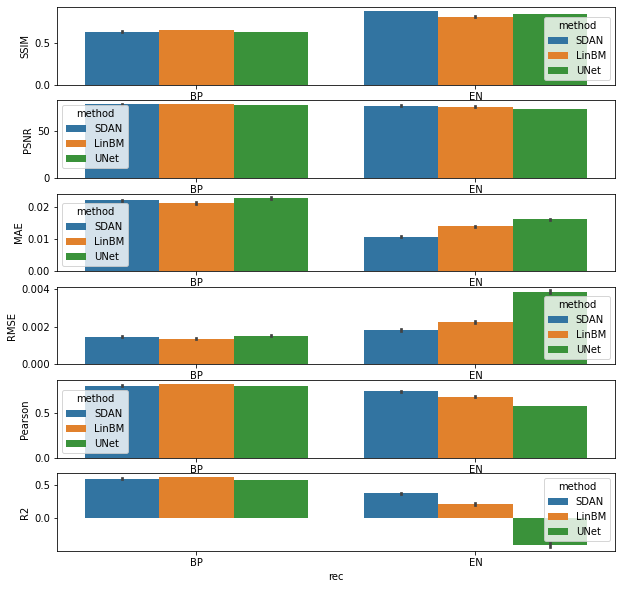

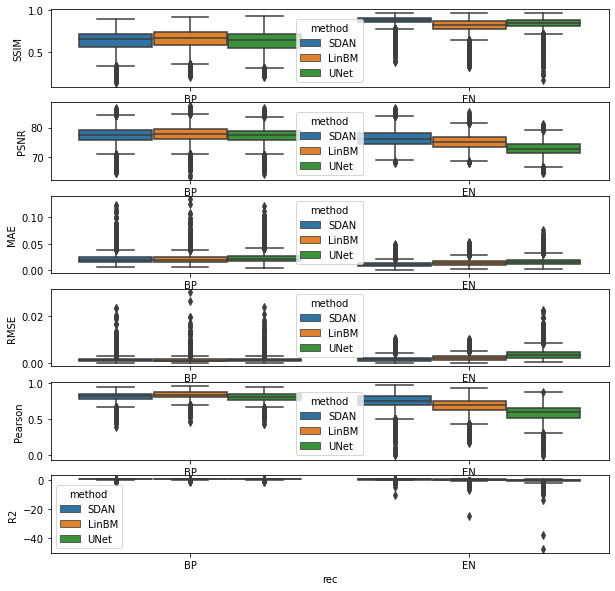

In [61]:
df_bp = pd.DataFrame.from_dict(metrics_bp_total)
df_bp['method'] = 'SDAN'
df_bp['rec'] = 'BP'

df_en = pd.DataFrame.from_dict(metrics_en_total)
df_en['method'] = 'SDAN'
df_en['rec'] = 'EN'

df_bp_linbm = pd.DataFrame.from_dict(metrics_lin_bp_total)
df_bp_linbm['method'] = 'LinBM'
df_bp_linbm['rec'] = 'BP'

df_en_linbm = pd.DataFrame.from_dict(metrics_lin_en_total)
df_en_linbm['method'] = 'LinBM'
df_en_linbm['rec'] = 'EN'

df_unet = pd.DataFrame.from_dict(metrics_unet_total)
df_unet['method'] = 'UNet'
df_unet['rec'] = 'BP'

df_unet_en = pd.DataFrame.from_dict(metrics_unet_en_total)
df_unet_en['method'] = 'UNet'
df_unet_en['rec'] = 'EN'
df = pd.concat([df_bp, df_en, df_bp_linbm, df_en_linbm, df_unet, df_unet_en]).reset_index()

methods = ['SSIM', 'PSNR', 'MAE', 'RMSE', 'Pearson', 'R2']

fig, ax = plt.subplots(len(methods), 1, figsize=(10,10))

for i,m in enumerate(methods):
    sns.barplot(data=df, x="rec", y=m, ax=ax[i], hue="method")
    
    
fig, ax = plt.subplots(len(methods), 1, figsize=(10,10))
for i,m in enumerate(methods):
    sns.boxplot(data=df, x="rec", y=m, ax=ax[i], hue="method")
    
df.groupby(['method', 'rec']).mean().sort_values('PSNR', ascending=False).style.format('{:.4f}')


In [62]:
df.groupby(['method', 'rec']).mean().sort_values('SSIM', ascending=False).style.format('{:.2f}')


In [64]:
df.groupby(['rec', 'method']).mean().style.format('{:.2f}')


In [2]:
batch = np.random.choice(1)
i = np.random.choice(256)
print(batch*256+i)
# batch=0
# i=215
file_input = f'{folder_rec}/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
file_plot = f'/home/anna/ResultsSignalDA/comparison_imgs/batch_{batch}_idx_{i}.png'
rec = h5py.File(file_input, 'r')
rec_bp = rec['BackProjection']
rec_en = rec['ElasticNet 1e-5']
    
get_images(i, batch, True, file_plot)

NameError: name 'np' is not defined

In [43]:
df_bp[df_bp.PSNR.values > 82]

,SSIM,PSNR,MAE,RMSE,Pearson,R2,batch,idx,method,rec
214,0.878942,85.509956,0.007434,0.000183,0.826276,0.547419,0,214,SDAN,BP
215,0.791674,82.010077,0.012231,0.000409,0.832794,0.693292,0,215,SDAN,BP
363,0.832975,82.416560,0.011266,0.000373,0.905219,0.723402,1,107,SDAN,BP
430,0.784135,82.036073,0.011518,0.000407,0.828643,0.567145,1,174,SDAN,BP
431,0.856369,85.379463,0.007721,0.000188,0.825417,0.573105,1,175,SDAN,BP
...,...,...,...,...,...,...,...,...,...,...
5418,0.787036,82.532098,0.011353,0.000363,0.869573,0.724126,21,42,SDAN,BP
5419,0.785170,82.173469,0.011794,0.000394,0.877995,0.749641,21,43,SDAN,BP
5425,0.793413,82.086342,0.011369,0.000402,0.861834,0.722472,21,49,SDAN,BP
5426,0.802936,82.327938,0.011032,0.000380,0.862121,0.723896,21,50,SDAN,BP


({'batch': 0,
  'idx': 1,
  'SSIM': 0.7059655975371257,
  'PSNR': 71.42160751841058,
  'MAE': 0.027767688,
  'RMSE': 0.004687266095201306,
  'Pearson': 0.738555982336902,
  'R2': 0.36026787162561846},
 {'batch': 0,
  'idx': 1,
  'SSIM': 0.3837472021063362,
  'PSNR': 71.24809156917402,
  'MAE': 0.049315766,
  'RMSE': 0.004878330325277368,
  'Pearson': 0.7640274046263796,
  'R2': 0.42482976991230237},
 {'batch': 0,
  'idx': 1,
  'SSIM': 0.3955812509803785,
  'PSNR': 71.45860327260274,
  'MAE': 0.048511874,
  'RMSE': 0.004647506789742566,
  'Pearson': 0.7629994748272679,
  'R2': 0.45204457850271074},
 {'batch': 0,
  'idx': 1,
  'SSIM': 0.5977977223012025,
  'PSNR': 71.6412739096189,
  'MAE': 0.030390289,
  'RMSE': 0.00445607990267173,
  'Pearson': 0.6606958067116299,
  'R2': 0.3918208562426275},
 {'batch': 0,
  'idx': 1,
  'SSIM': 0.3873495149929427,
  'PSNR': 71.87608762736997,
  'MAE': 0.046046615,
  'RMSE': 0.004221546698495616,
  'Pearson': 0.7405178763920344,
  'R2': 0.50226659041141

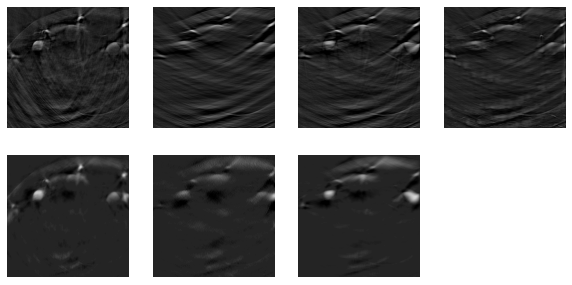

In [57]:
batch = np.random.choice(1)
i = np.random.choice(np.array([i for i in df_en[df_en.SSIM.values < 0.75].idx.values]))
batch=0
i = 168
# i=215
file_input = f'{folder_rec}/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
file_plot = f'/home/anna/ResultsSignalDA/comparison_imgs/batch_{batch}_idx_{i}.png'
rec = h5py.File(file_input, 'r')
rec_bp = rec['BackProjection']
rec_en = rec['ElasticNet 1e-5']
    
get_images(i, batch, True, file_plot)

In [1]:
# batch = np.random.choice(1)
# i = np.random.choice(np.array([i for i in df_en[df_en.SSIM.values < 0.75].idx.values]))
# batch=0
# i = 168
# i=215

idx_test = [0, 1, 28, 29, 139, 142, 168, 204, 285, 428, 570, 713, 856, 998, 1141, 1284, 1426,
            1569, 1712, 1854, 1997, 2140, 2282, 2425, 2568, 2710, 2853, 2996, 3138, 
            3281, 3424, 3566, 3709, 3851, 3994, 4137, 4280, 4422]
# idx_test = [13]
for idx in idx_test:
    batch = idx // 256
    i = idx % 256
    file_input = f'{folder_rec}/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
    # file_plot = f'/home/anna/ResultsSignalDA/comparison_imgs/batch_{batch}_idx_{i}.png'
    file_plot = f'./PaperFigures/Figure3-v2/batch_{batch}_idx_{i}.png'
    rec = h5py.File(file_input, 'r')
    rec_bp = rec['BackProjection']
    rec_en = rec['ElasticNet 1e-5']
        
    get_images(i, batch, True, file_plot)

NameError: name 'folder_rec' is not defined

In [70]:

# batch = np.random.choice(1)
# i = np.random.choice(32)
# batch=3
# i=203
# file_input = f'{folder_rec}/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
# file_plot = f'/home/anna/ResultsSignalDA/comparison_imgs/batch_{batch}_idx_{i}.png'
# rec = h5py.File(file_input, 'r')
# rec_bp = rec['BackProjection']
# rec_en = rec['ElasticNet 1e-5']
    
# get_images(i, batch, True, file_plot)

# Ablation study

Side impute with RC wo Style

In [20]:
path = './MIDL/validation/'
side_wo_style = f'{path}/Behnch1024_woStyle_L2_full_styleNone_2022-02-10/Reconstructions/Real_multi_signal_with_RC/Real_multi_signal_with_RC.h5',